# 🎧 Speech Emotion Recognition with Diffusion Models
This project implements a deep learning pipeline to recognize and generate emotional speech using mel-spectrograms, ResNet-50, and a diffusion model. We preprocess two datasets (EmoDB and RAVDESS), analyze them, and prepare inputs for an emotion embedding and augmentation framework.



## 1. Business Understanding

### Problem Statement
- **Challenge**: Emotion recognition in audio signals requires high-quality data with clear emotional characteristics
- **Current Issues**: Limited availability of high-quality emotional speech datasets
- **Solution Approach**: Use generative models to enhance emotional clarity in existing datasets

### Business Value
- Improved emotion recognition systems for call centers, virtual assistants, and healthcare applications
- Cost-effective generation of high-quality emotional speech data
- Enhanced emotional expressiveness in speech synthesis applications
- Data augmentation services for AI training


## 2. Data Understanding

### Datasets
- **EmoDB**: German emotional speech dataset
  - 10 speakers (5 male, 5 female)
  - Emotions: neutral, happy, sad, angry, fear, disgust
  - 16 kHz sampling rate
  - 454 total samples

- **RAVDESS**: English emotional speech dataset
  - 24 speakers (12 male, 12 female)
  - Emotions: neutral, happy, sad, angry, fear, disgust (surprised in original)
  - 48 kHz sampling rate
  - 1056 total samples

### Data Exploration
- Distribution of emotions across datasets
- Mel-spectrogram visualizations for different emotions
- Audio sample analysis
- Correlation between audio features and emotions

### Preprocessing Steps
- Resampling both datasets to 22,025 Hz
- Padding all samples to 10 seconds length
- Converting audio to mel-spectrograms using STFT
  - Window size: 1024
  - Hop length: 256
  - Number of mel bands: 80
- Z-score normalization of mel-spectrograms
- Train/test split (80%/20%)


In [ ]:
!pip install librosa numpy matplotlib soundfile --quiet
!pip install torch torchvision torchaudio --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00


In [ ]:
# Système et avertissements
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Manipulation de données
import numpy as np
import pandas as pd
from collections import Counter

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Audio
import librosa
import librosa.display
from IPython.display import Audio

# Machine Learning et prétraitement
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score,
    precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve
)

# Deep Learning - TensorFlow / Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torchvision.models as models

# Utilitaires
from tqdm import tqdm

# Dataset personnalisé
from dataset import EmotionalSpeechDataset

# Google Drive (si utilisé avec Google Colab)
from google.colab import drive


In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Vérifiez si le dossier existe
directory = "/content/drive/MyDrive/DL project 2425/RAVDESS"
if os.path.isdir(directory):
    print("Le dossier existe !")
else:
    print("Le dossier n'existe pas.")





Le dossier existe !


In [ ]:


# Vérifiez si le dossier existe
directory = "/content/drive/MyDrive/DL project 2425/EmoDB/wav"
if os.path.isdir(directory):
    print("Le dossier existe !")
else:
    print("Le dossier n'existe pas.")

Le dossier existe !


# Data understanding

In [ ]:


# Path to extracted data (adjust based on your extraction_path)
emoDB_path = "/content/drive/MyDrive/DL project 2425/EmoDB/wav"
ravdess_path = "/content/drive/MyDrive/DL project 2425/RAVDESS"

# List files in each dataset
emoDB_files = os.listdir(emoDB_path)
ravdess_files = os.listdir(ravdess_path)

print(f"EmoDB files: {len(emoDB_files)}")
print(f"RAVDESS files: {len(ravdess_files)}")

EmoDB files: 535
RAVDESS files: 25


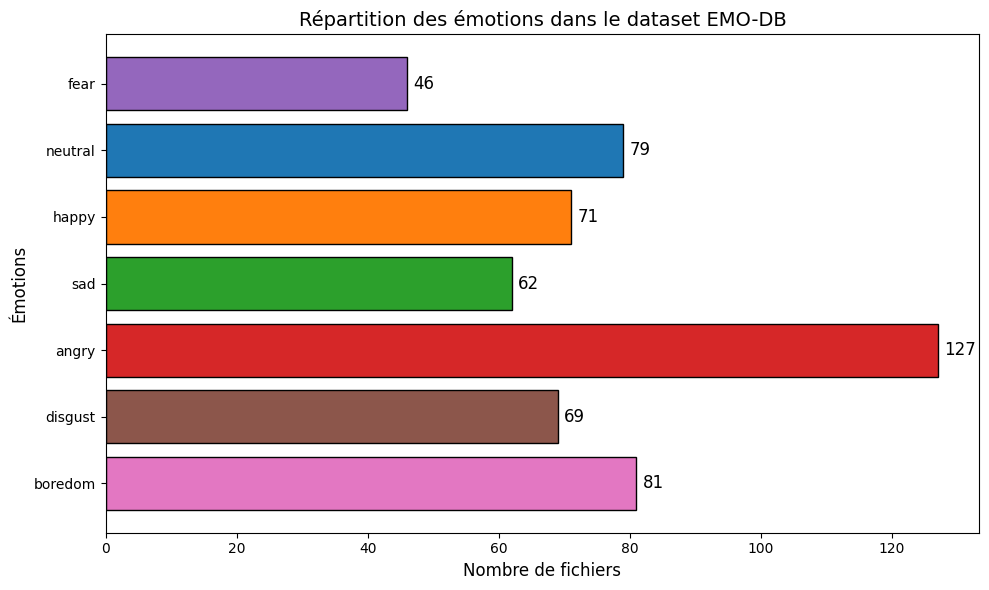

Répartition des émotions dans EmoDB: Counter({'angry': 127, 'boredom': 81, 'neutral': 79, 'happy': 71, 'disgust': 69, 'sad': 62, 'fear': 46})


In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
from collections import Counter

# Répertoire principal contenant EmoDB
base_dir = '/content/drive/MyDrive/DL project 2425/EmoDB'

# Extraction (optionnel)
emo_db_zip = os.path.join(base_dir, 'EmoDB.zip')
if os.path.exists(emo_db_zip):
    with zipfile.ZipFile(emo_db_zip, 'r') as zip_ref:
        zip_ref.extractall(base_dir)
        print(f"✅ Extraction de {emo_db_zip} vers {base_dir}")
    os.remove(emo_db_zip)

# Codes des émotions
emotion_codes = {
    'N': 'neutral',
    'F': 'happy',
    'T': 'sad',
    'W': 'angry',
    'E': 'fear',
    'A': 'disgust',
    'L': 'boredom'
}

# Dossier des fichiers audio
audio_dir = os.path.join(base_dir, 'wav')

# Liste des émotions détectées
detected_emotions = []

for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        emotion_code = filename[5]
        emotion = emotion_codes.get(emotion_code, "unknown")
        detected_emotions.append(emotion)

# Comptage
emotion_count = Counter(detected_emotions)
labels = list(emotion_count.keys())
values = list(emotion_count.values())

# Palette de couleurs personnalisée (autant que d'émotions)
emotion_colors = {
    'neutral': '#1f77b4',    # bleu
    'happy': '#ff7f0e',      # orange
    'sad': '#2ca02c',        # vert
    'angry': '#d62728',      # rouge
    'fear': '#9467bd',       # violet
    'disgust': '#8c564b',    # brun
    'boredom': '#e377c2'     # rose
}
bar_colors = [emotion_colors.get(emotion, 'gray') for emotion in labels]

# Affichage
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, values, color=bar_colors, edgecolor='black')
plt.title("Répartition des émotions dans le dataset EMO-DB", fontsize=14)

# Labels sur les barres
for i, (label, value) in enumerate(zip(labels, values)):
    plt.text(value + 1, i, f'{value}', va='center', fontsize=12, color='black')

plt.xlabel("Nombre de fichiers", fontsize=12)
plt.ylabel("Émotions", fontsize=12)
plt.tight_layout()
plt.show()

# Affichage console
print("Répartition des émotions dans EmoDB:", emotion_count)


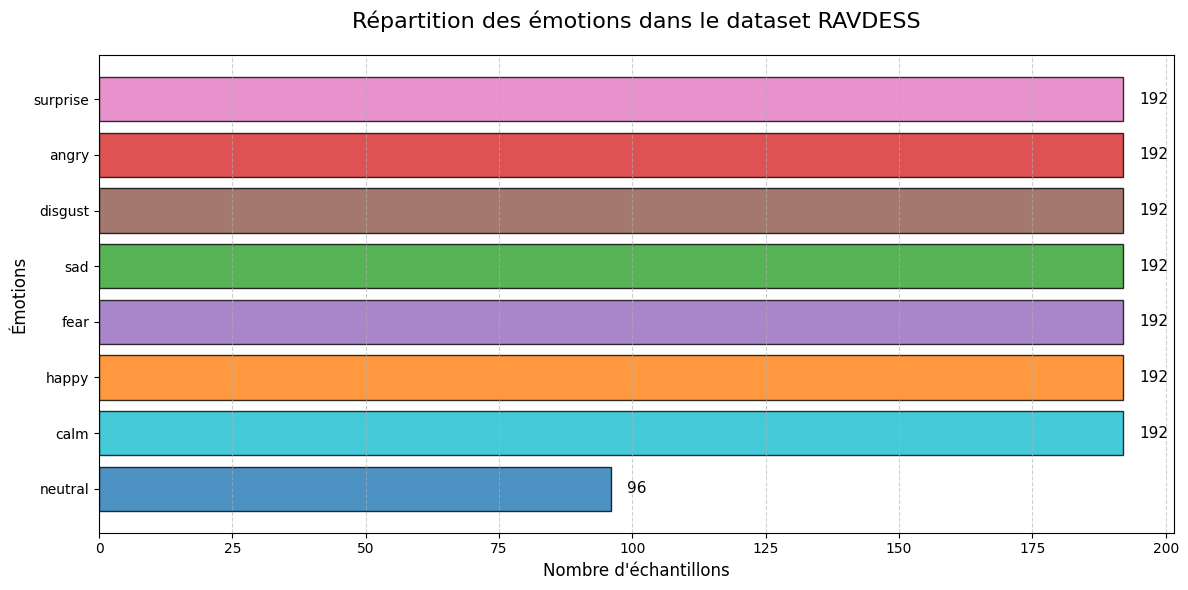

In [ ]:
# Dictionnaire des émotions pour RAVDESS
emotion_codes = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
    '08': 'surprise'
}

# Palette personnalisée : une couleur différente pour chaque émotion
emotion_colors = {
    'neutral': '#1f77b4',
    'calm': '#17becf',
    'happy': '#ff7f0e',
    'sad': '#2ca02c',
    'angry': '#d62728',
    'fear': '#9467bd',
    'disgust': '#8c564b',
    'surprise': '#e377c2',
    'inconnue': 'gray'
}

# Chemin vers le dataset
chemin = "/content/drive/MyDrive/DL project 2425/RAVDESS"

# Liste pour stocker les émotions trouvées
emotions_found = []

# Parcours des fichiers
for acteur in os.listdir(chemin):
    acteur_path = os.path.join(chemin, acteur)
    if os.path.isdir(acteur_path):
        for nom_fichier in os.listdir(acteur_path):
            if nom_fichier.endswith(".wav"):
                emotion_code = nom_fichier[6:8]
                emotion = emotion_codes.get(emotion_code, "inconnue")
                emotions_found.append(emotion)

# Comptage des émotions
emotion_counts = Counter(emotions_found)

# Tri des émotions par fréquence
sorted_emotions = sorted(emotion_counts.items(), key=lambda x: x[1])
labels = [e[0] for e in sorted_emotions]
values = [e[1] for e in sorted_emotions]
bar_colors = [emotion_colors.get(emotion, 'gray') for emotion in labels]

# Création de l'histogramme horizontal
plt.figure(figsize=(12, 6))
bars = plt.barh(labels, values, color=bar_colors, edgecolor='black', alpha=0.8)

# Personnalisation du graphique
plt.title("Répartition des émotions dans le dataset RAVDESS", fontsize=16, pad=20)
plt.xlabel("Nombre d'échantillons", fontsize=12)
plt.ylabel("Émotions", fontsize=12)

# Ajout des valeurs sur les barres
for bar in bars:
    width = bar.get_width()
    plt.text(width + 3, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             va='center', ha='left', fontsize=11)

# Grille et mise en forme
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**DATA PREPARATION**

In [ ]:
dataset_code = """
import torchaudio
import torch
import pathlib
import torch.nn.functional as F
from torch.utils.data import Dataset

SR = 22025          # Sampling rate (how many samples per second)
N_FFT = 1024        # Number of points in FFT (used for spectrogram)
HOP = 256           # Step size between FFT windows
N_MELS = 80         # Number of Mel frequency bins
MAX_SECS = 10       # Max audio length (in seconds)

class EmotionalSpeechDataset(Dataset):
    def __init__(self, root_dir, dataset_name, emotions, transform=None):
        self.root_dir     = pathlib.Path(root_dir)
        self.dataset_name = dataset_name
        self.emotions     = emotions
        self.transform    = transform
        self.samples      = self._scan()

        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS, power=2.0
        )
        self.to_db = torchaudio.transforms.AmplitudeToDB()

    def _scan(self):
        out = []
        if self.dataset_name.lower() == "emodb":
            mapping = dict(W='anger', L='boredom', E='disgust', A='fear',
                           F='happiness', T='sadness', N='neutral')
            for wav in self.root_dir.glob("*.wav"):
                emo = mapping.get(wav.name[5])
                if emo in self.emotions:
                    out.append((wav, self.emotions.index(emo)))
        elif self.dataset_name.lower() == "ravdess":
            mapping = {
                f"{i:02d}": e for i, e in enumerate(
                    ['neutral','calm','happiness','sadness','anger','fear','disgust','surprise'], 1)
            }
            for wav in self.root_dir.rglob("*.wav"):
                try:
                    emo_code = wav.name.split('-')[2]
                    emo = mapping.get(emo_code)
                    if emo in self.emotions:
                        out.append((wav, self.emotions.index(emo)))
                except Exception as e:
                    print(f"Skipping {wav.name}: {e}")
                if emo in self.emotions:
                    out.append((wav, self.emotions.index(emo)))
        return out

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, emo_idx = self.samples[idx]
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != SR:
            wav = torchaudio.transforms.Resample(sr, SR)(wav)

        target_len = SR * MAX_SECS
        if wav.shape[1] < target_len:
            wav = F.pad(wav, (0, target_len - wav.shape[1]))
        else:
            wav = wav[:, :target_len]

        mel = self.to_db(self.mel(wav))
        mel = (mel - mel.mean()) / (mel.std() + 1e-8)

        if self.transform:
            mel = self.transform(mel)

        return {
            "waveform": wav,
            "mel_spectrogram": mel,
            "emotion": emo_idx,
            "path": str(path),
        }
"""

# Write it to file
with open("dataset.py", "w") as f:
    f.write(dataset_code)

### **Emotional Speech Data Pipeline: Loading, Merging & Splitting EmoDB & RAVDESS**

In [ ]:
# List of target emotions
emotions = ['neutral', 'happiness', 'sadness', 'anger', 'fear', 'disgust']

# Your Drive paths
emodb_path = "/content/drive/MyDrive/DL project 2425/EmoDB"
ravdess_path = "/content/drive/MyDrive/DL project 2425/RAVDESS"

# Load datasets
emodb_ds = EmotionalSpeechDataset(emodb_path, "emodb", emotions)
rav_ds = EmotionalSpeechDataset(ravdess_path, "ravdess", emotions)

# Combine datasets
full_ds = ConcatDataset([emodb_ds, rav_ds])

# Split into training and testing sets (80/20)
train_len = int(0.8 * len(full_ds))
test_len = len(full_ds) - train_len
train_ds, test_ds = random_split(full_ds, [train_len, test_len])

# Data loader parameters
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count() // 2

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)


### **Mel-Spectrogram & Waveform Visualization**

In [ ]:
def visualize_emotion_spectrograms(dataset, emotions, num_examples=1, figsize=(18, 15)):
    """
       The function:
        - Randomly selects samples for each emotion
        - Plots their mel-spectrogram and waveform
        - Provides audio playback for each emotion

    A PNG of the plots is saved as 'emotion_mel_spectrograms.png'
    """


    # Initialize structure to map emotion labels to sample indices
    emotion_to_indices = {i: [] for i in range(len(emotions))}

    # Iterate through dataset to gather indices per emotion label
    for idx in range(len(dataset)):
        try:
            entry = dataset[idx]
            label = entry['emotion']
            label_idx = label if isinstance(label, int) else label.item()
            emotion_to_indices[label_idx].append(idx)
        except Exception as err:
            print(f"Skipping index {idx} due to error: {err}")
            continue

    # Setup plot grid dimensions
    num_rows = len(emotions)
    num_cols = 2  # Spectrogram and waveform

    plt.figure(figsize=figsize)

    # Visualize one random example per emotion
    for i, emotion_label in enumerate(emotions):
        if not emotion_to_indices.get(i):
            print(f"No data available for emotion: {emotion_label}")
            continue

        # Randomly pick one example for the current emotion
        chosen_idx = np.random.choice(emotion_to_indices[i])
        sample = dataset[chosen_idx]

        # Extract mel-spectrogram
        mel = sample['mel_spectrogram']
        if isinstance(mel, torch.Tensor):
            mel = mel.cpu().numpy()
        if mel.ndim > 2:
            mel = np.squeeze(mel)

        # Extract waveform if present
        waveform = sample.get('waveform')
        if waveform is not None and isinstance(waveform, torch.Tensor):
            waveform = waveform.cpu().numpy()
            if waveform.ndim > 1:
                waveform = np.squeeze(waveform)

        # Plot spectrogram
        plt.subplot(num_rows, num_cols, i * num_cols + 1)
        librosa.display.specshow(
            mel, sr=22025, hop_length=256, x_axis='time', y_axis='mel'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{emotion_label} - Mel-Spectrogram")

        # Plot waveform if available
        if waveform is not None:
            plt.subplot(num_rows, num_cols, i * num_cols + 2)
            plt.plot(waveform)
            plt.title(f"{emotion_label} - Waveform")
            plt.xlim(0, len(waveform))
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('emotion_spectrogram_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Audio previews
    print("\nAudio previews by emotion:")
    for i, emotion_label in enumerate(emotions):
        if not emotion_to_indices.get(i):
            continue

        chosen_idx = np.random.choice(emotion_to_indices[i])
        sample = dataset[chosen_idx]
        waveform = sample.get('waveform')

        if waveform is not None:
            if isinstance(waveform, torch.Tensor):
                waveform = waveform.cpu().numpy()
            if waveform.ndim > 1:
                waveform = np.squeeze(waveform)

            print(f"\n{emotion_label} sample:")
            display(Audio(waveform, rate=22025))


In [ ]:
import multiprocessing as mp
if mp.get_start_method(allow_none=True) != 'spawn':
    mp.set_start_method('spawn', force=True)


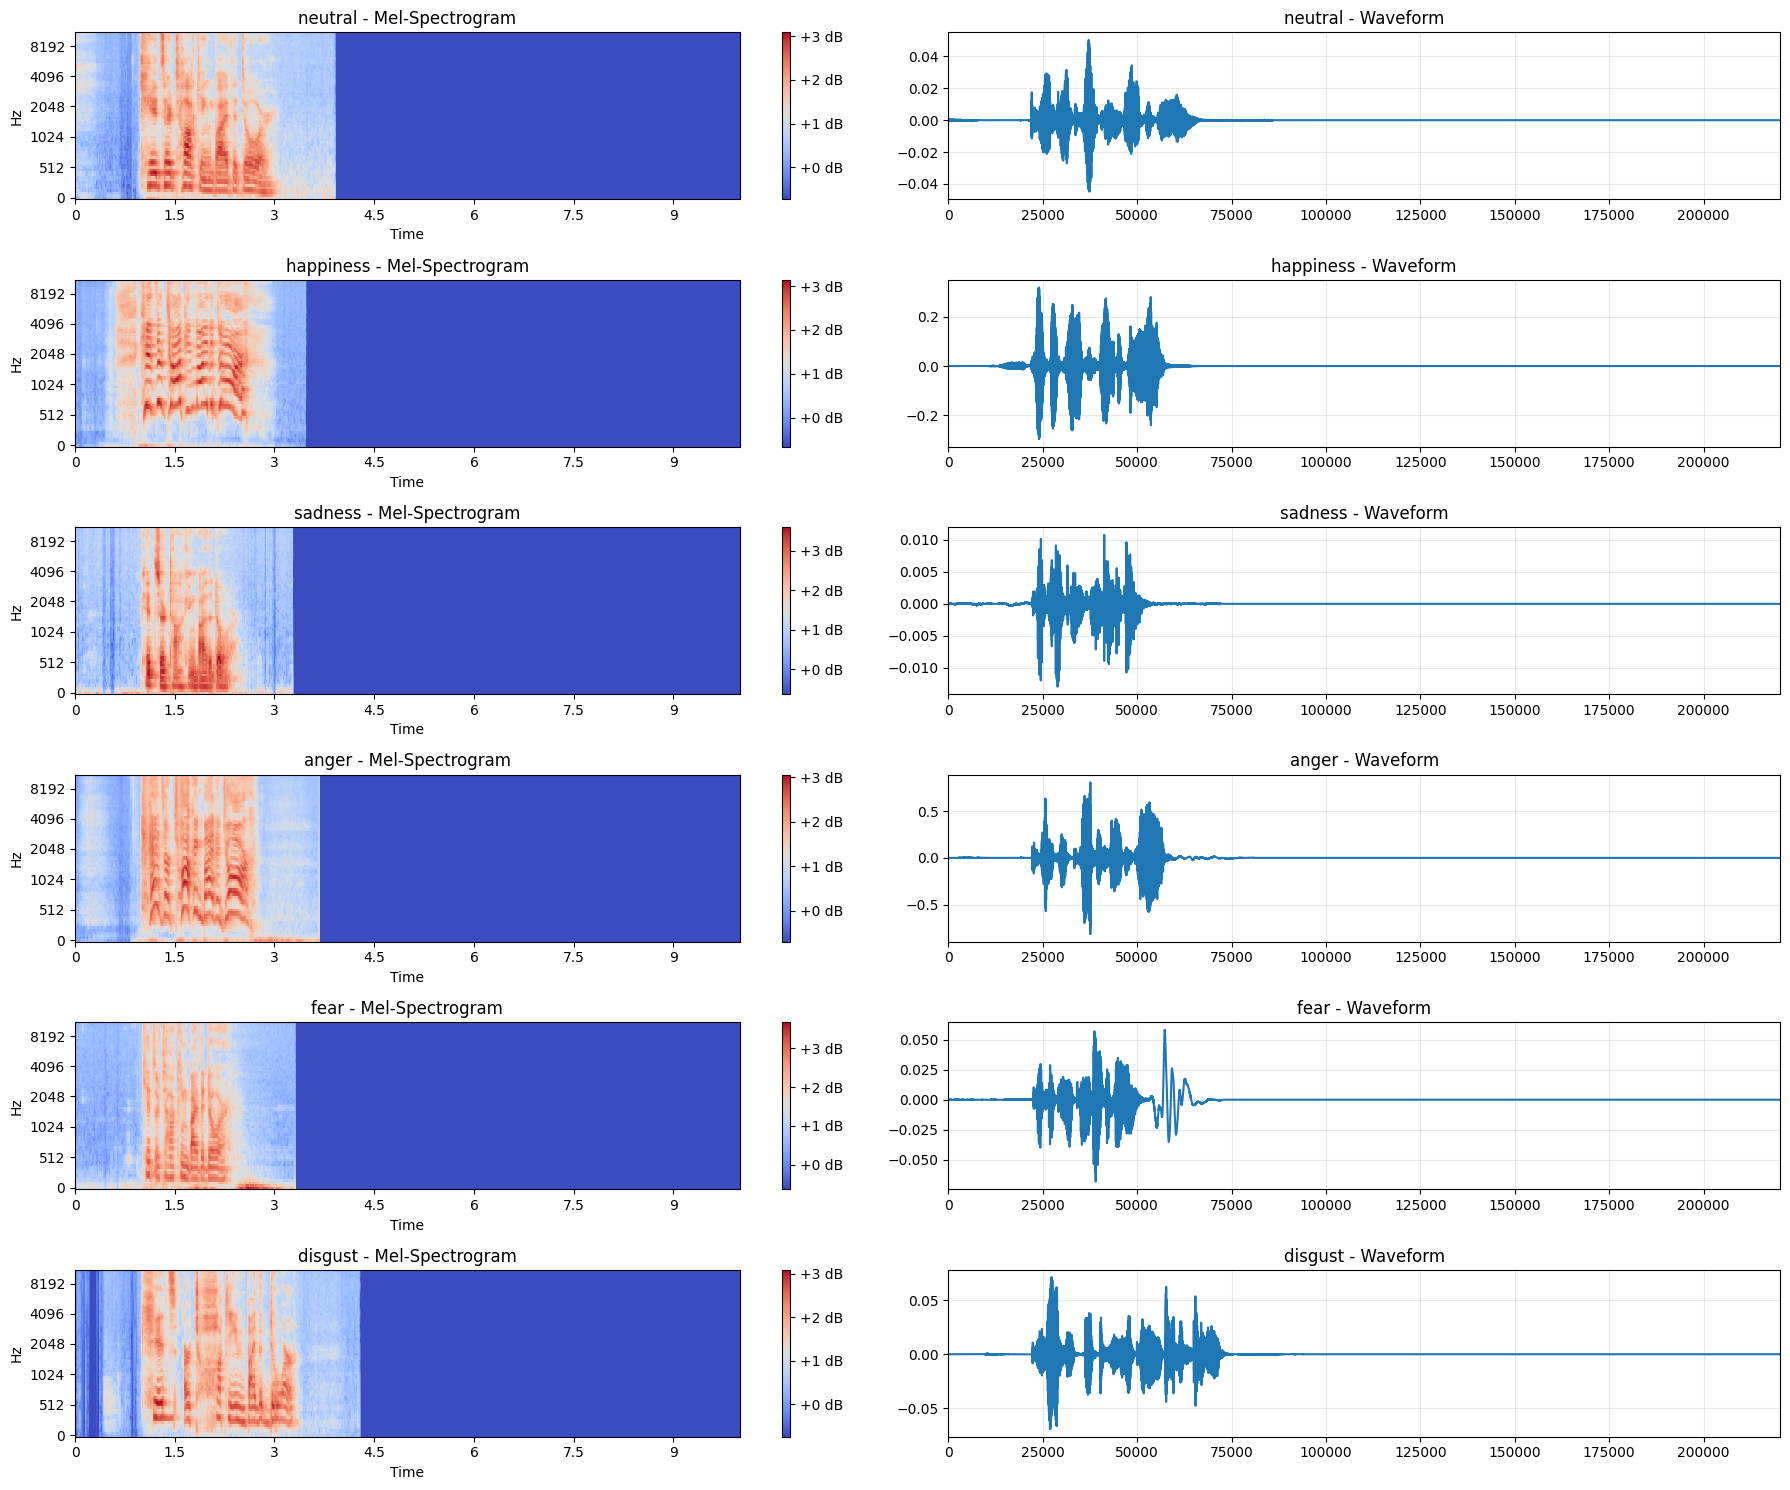


Audio previews by emotion:

neutral sample:



happiness sample:



sadness sample:



anger sample:



fear sample:



disgust sample:


In [ ]:
visualize_emotion_spectrograms(
    train_ds,  # Your dataset
    emotions=["neutral", "happiness", "sadness", "anger", "fear", "disgust"],
    figsize=(18, 15)  # Adjust figure size as needed
)

### **Data Split (Split train & test)**

In [ ]:
def visualize_dataset(train_ds, test_ds, emotions):
    """
    Visualize the distribution of emotions in the datasets
    """
    print("Analyzing dataset distribution...")

    # Count emotions in training set
    train_emotions = []
    for i in range(len(train_ds)):
        try:
            sample = train_ds[i]
            train_emotions.append(sample['emotion'])
        except:
            pass

    # Count emotions in test set
    test_emotions = []
    for i in range(len(test_ds)):
        try:
            sample = test_ds[i]
            test_emotions.append(sample['emotion'])
        except:
            pass

    # Convert to numpy arrays for counting
    train_emotions = np.array(train_emotions)
    test_emotions = np.array(test_emotions)

    # Create counts
    train_counts = [np.sum(train_emotions == i) for i in range(len(emotions))]
    test_counts = [np.sum(test_emotions == i) for i in range(len(emotions))]

    # Plot emotion distribution
    plt.figure(figsize=(12, 10))

    # Training set distribution
    plt.subplot(2, 1, 1)
    bars = plt.bar(emotions, train_counts, color='skyblue')
    plt.title('Emotion Distribution in Training Set', fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on top of bars
    for bar, count in zip(bars, train_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(count), ha='center', fontsize=10)

    # Test set distribution
    plt.subplot(2, 1, 2)
    bars = plt.bar(emotions, test_counts, color='salmon')
    plt.title('Emotion Distribution in Test Set', fontsize=14)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on top of bars
    for bar, count in zip(bars, test_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(count), ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('emotion_distribution.png')
    plt.show()

    # Visualize sample mel-spectrograms for each emotion
    plt.figure(figsize=(15, 10))

    # Get one example of each emotion from training set
    for i, emotion in enumerate(emotions):
        emotion_idx = emotions.index(emotion)
        # Find samples with this emotion
        samples = [j for j in range(len(train_ds)) if
                   train_ds[j]['emotion'] == emotion_idx]

        if samples:
            # Get a sample
            sample_idx = samples[0]
            mel = train_ds[sample_idx]['mel_spectrogram']

            # Plot
            plt.subplot(2, 3, i+1)
            if isinstance(mel, torch.Tensor):
                mel = mel.squeeze().cpu().numpy()
            librosa.display.specshow(
                mel, sr=SR, hop_length=TRIM_HOP_LENGTH if SMALLER_MODEL else HOP,
                y_axis='mel', x_axis='time'
            )
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Mel-Spectrogram: {emotion}')

    plt.tight_layout()
    plt.savefig('emotion_spectrograms.png')
    plt.show()

Analyzing dataset distribution...


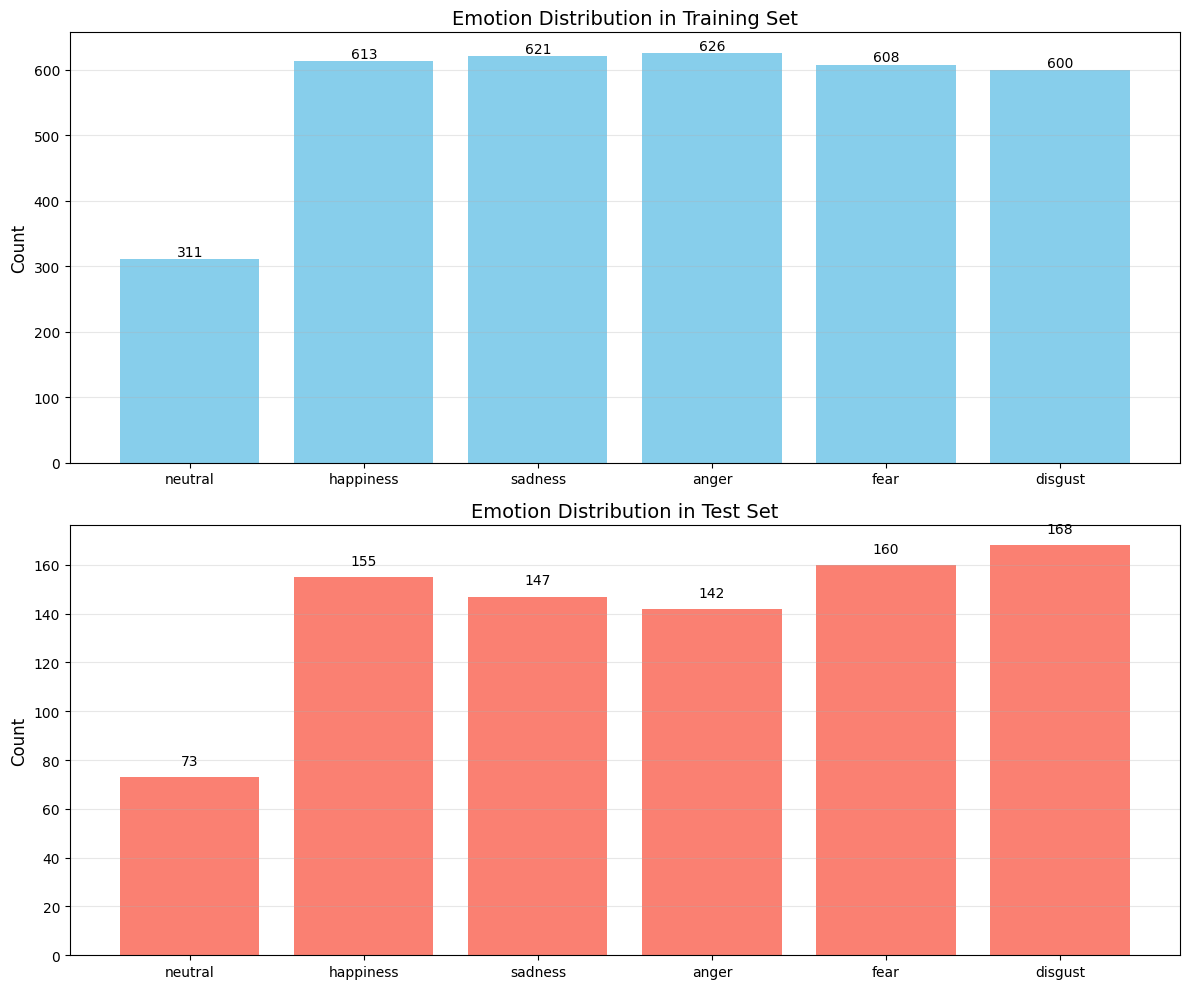

NameError: name 'SR' is not defined

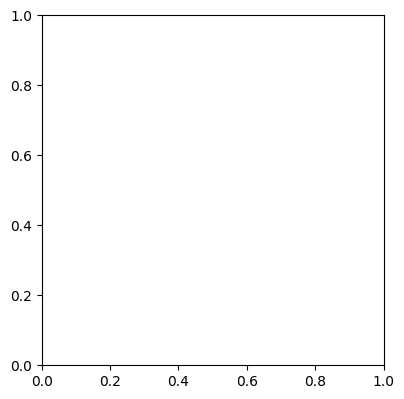

In [ ]:
visualize_dataset(train_ds, test_ds, emotions)

4.Modeling

This model adapts ResNet50 to analyze speech spectrograms, outputting both emotion predictions (like happy/angry) and compact voice features


*   Standard ResNet-50 model (originally designed for 3-channel RGB images)

*   Internal structure: Initial convolution → BatchNorm → ReLU → MaxPooling


*   Adaptations for audio emotion recognition:
    *   Modified input layer for spectrogram processing
    *   Custom emotion classification head
    *   Optimized for 1D/2D audio feature inputs

In [ ]:
class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_emotions: int):
        super().__init__()
        self.backbone = models.resnet50(weights=None)
        self.backbone.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        dim = self.backbone.fc.in_features

        # Nouveau FC + Dropout
        self.dropout = nn.Dropout(p=0.6)
        self.backbone.fc = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),
            self.dropout,
            nn.Linear(256, num_emotions)
        )
        self.embedding = nn.Linear(dim, 256)

    def forward(self, x, return_embedding=False):
        x = self.backbone.conv1(x); x = self.backbone.bn1(x)
        x = self.backbone.relu(x); x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x); x = self.backbone.layer2(x)
        x = self.backbone.layer3(x); x = self.backbone.layer4(x)
        x = self.backbone.avgpool(x)
        feats = torch.flatten(x, 1)
        out = self.backbone.fc(feats)
        if return_embedding:
            return out, self.embedding(feats)
        return out


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [ ]:
def train_ser(model, train_loader, val_loader, *, epochs=15, log_every=1, patience=5):
    model.to(DEVICE)
    opt  = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # ✅ L2 régularisation
    crit = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=2, factor=0.5, verbose=True)

    early_stopping = EarlyStopping(patience=patience, delta=0.01)

    best_val_loss = float('inf')
    best_model_state = None

    for ep in range(epochs):
        model.train()
        loss_sum = correct = total = 0
        pbar = tqdm(train_loader, desc=f"[SER] epoch {ep+1}/{epochs}", leave=False)

        for batch in pbar:
            mel = batch["mel_spectrogram"].to(DEVICE)
            lab = batch["emotion"].to(DEVICE)

            opt.zero_grad()
            out = model(mel)
            loss = crit(out, lab)
            loss.backward(); opt.step()

            loss_sum += loss.item()
            pred = out.argmax(1)
            correct += (pred == lab).sum().item()
            total += lab.size(0)

            pbar.set_postfix(loss=f"{loss_sum / (total // lab.size(0) + 1):.4f}", acc=f"{correct / total:.3%}")

        # Validation
        model.eval()
        val_loss_sum = correct_val = total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                mel = batch["mel_spectrogram"].to(DEVICE)
                lab = batch["emotion"].to(DEVICE)
                out = model(mel)
                val_loss = crit(out, lab)
                val_loss_sum += val_loss.item()
                pred = out.argmax(1)
                correct_val += (pred == lab).sum().item()
                total_val += lab.size(0)

        val_loss = val_loss_sum / len(val_loader)
        val_acc = correct_val / total_val
        scheduler.step(val_loss)

        if (ep + 1) % log_every == 0:
            print(f"[SER] ep {ep+1:>3}/{epochs}  "
                  f"train loss {loss_sum/len(train_loader):.4f}  "
                  f"train acc {correct/total:.3%}  "
                  f"val loss {val_loss:.4f}  "
                  f"val acc {val_acc:.3%}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {ep+1}.")
            break

    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Définir la taille du lot et le nombre de workers
BATCH_SIZE = 16
NUM_WORKERS = 4

# Supposons que `train_ds` est déjà défini (ton dataset d'entraînement)
# Séparer l'ensemble de validation (par exemple, 20% des données d'entraînement pour la validation)
train_len = int(0.8 * len(train_ds))  # 80% pour l'entraînement
val_len = len(train_ds) - train_len    # 20% pour la validation

train_ds, val_ds = random_split(train_ds, [train_len, val_len])

# Charge les DataLoader pour les ensembles d'entraînement et de validation
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
ser = EmotionRecognitionModel(num_emotions=len(emotions))
train_ser(ser, train_loader, val_loader, epochs=30, patience=5)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[SER] ep   1/30  train loss 1.6905  train acc 26.318%  val loss 1.5522  val acc 34.750%


[SER] ep   2/30  train loss 1.4831  train acc 37.327%  val loss 1.6788  val acc 31.608%


[SER] ep   3/30  train loss 1.2574  train acc 48.890%  val loss 1.5416  val acc 41.035%


[SER] ep   4/30  train loss 1.0403  train acc 59.482%  val loss 0.8756  val acc 65.619%


[SER] ep   5/30  train loss 0.8154  train acc 69.334%  val loss 0.6377  val acc 75.970%


[SER] ep   6/30  train loss 0.6929  train acc 74.376%  val loss 1.4107  val acc 43.438%


[SER] ep   7/30  train loss 0.5342  train acc 80.296%  val loss 0.6539  val acc 73.013%


[SER] ep   8/30  train loss 0.5049  train acc 82.979%  val loss 1.1433  val acc 65.250%


[SER] ep   9/30  train loss 0.2903  train acc 91.674%  val loss 0.2508  val acc 90.388%


[SER] ep  10/30  train loss 0.2040  train acc 94.403%  val loss 0.1831  val acc 93.900%


[SER] ep  11/30  train loss 0.1500  train acc 96.022%  val loss 0.2131  val acc 94.085%


[SER] ep  12/30  train loss 0.1559  train acc 95.930%  val loss 0.2055  val acc 92.421%


[SER] ep  13/30  train loss 0.1425  train acc 96.300%  val loss 0.1608  val acc 94.455%


[SER] ep  14/30  train loss 0.1916  train acc 94.958%  val loss 0.4035  val acc 87.985%


[SER] ep  15/30  train loss 0.1857  train acc 95.375%  val loss 0.1871  val acc 94.640%


[SER] ep  16/30  train loss 0.1012  train acc 97.780%  val loss 0.1606  val acc 95.194%


[SER] ep  17/30  train loss 0.1146  train acc 97.734%  val loss 0.3560  val acc 89.649%


[SER] ep  18/30  train loss 0.0907  train acc 97.780%  val loss 0.1838  val acc 94.824%
Early stopping triggered at epoch 18.


In [ ]:
# Sauvegarder le modèle
save_path = '/content/drive/MyDrive/resnet_emodb.pth'
torch.save(ser.state_dict(), save_path)

print(f"✅ Model saved successfully at {save_path}")

✅ Model saved successfully at /content/drive/MyDrive/resnet_emodb.pth


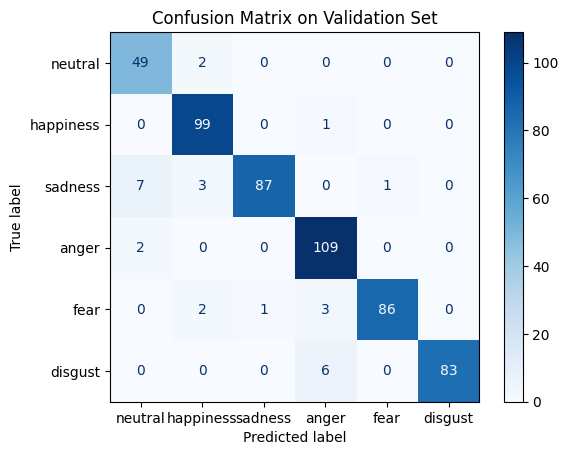

In [ ]:
# ➤ Get true labels & predicted labels
true_labels = []
predicted_labels = []

ser.eval()
with torch.no_grad():
    for batch in val_loader:
        inputs = batch["mel_spectrogram"].to(DEVICE)
        labels = batch["emotion"].to(DEVICE)
        outputs = ser(inputs)
        preds = torch.argmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# ➤ Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)  # Assure-toi que `emotions` contient les bons noms d’émotions
disp.plot(cmap='Blues')
plt.title('Confusion Matrix on Validation Set')
plt.show()

Diffision model


## **Purpose: modifies speech spectrograms with emotion control**.

## 2. Diffusion Model
Layer Structure:


    - ✅ Initial input layer: (32, 80, 861) → (32, 256, 861)
    - ✅ ResNet block: (32, 256, 861) → (32, 256, 861) with stride 1
    - ✅ Downsample: (32, 256, 861) → (32, 512, 430) with stride 2
    - ✅ ResNet block: (32, 512, 430) → (32, 1024, 215)
    - ✅ Upsample: (32, 1024, 215) → (32, 512, 430) with stride 2
    - ✅ ResNet block: (32, 512, 430) → (32, 256, 861)
    - ✅ Final Conv2d: (32, 256, 861) → (32, 1, 861) with stride 1


Additional Components:


    - ✅ ResNet blocks with time embeddings (as shown in Figure 2)
    - ✅ Attention mechanism in ResNet blocks (mentioned in Section 4.3)
    - ✅ Emotion embedding integration (as described in Section 4.3)
    - ✅ Sinusoidal position embeddings for temporal information






In [ ]:


# Attention Block as mentioned in the paper
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-2:]
        x = x.flatten(2).transpose(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.transpose(1, 2).view(-1, self.channels, *size)


# ResNet Block with gradient checkpointing
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels=512, use_attn=False, dropout=0.1):
        super(ResnetBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_attn = use_attn

        # Enable gradient checkpointing to save memory
        self.use_checkpoint = True

        self.norm1 = nn.GroupNorm(32, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)

        # Time embedding projection
        self.temb_proj = nn.Linear(temb_channels, out_channels)

        self.norm2 = nn.GroupNorm(32, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        if self.in_channels != self.out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

        # Add attention block only if use_attn is True
        if use_attn:
            self.attn = AttentionBlock(out_channels)

    def forward(self, x, temb):
        # Use gradient checkpointing to save memory
        if self.use_checkpoint and x.requires_grad:
            return torch.utils.checkpoint.checkpoint(
                self._forward, x, temb
            )
        else:
            return self._forward(x, temb)

    def _forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = F.silu(h)
        h = self.conv1(h)

        # Add time embedding
        temb = self.temb_proj(F.silu(temb))[:, :, None, None]
        h = h + temb

        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        # Apply attention only if use_attn is True
        if self.use_attn:
            h = self.attn(h)

        return h + self.shortcut(x)

# Sinusoidal position embedding
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings like in the original DDPM paper.
    """
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    if embedding_dim % 2 == 1:  # zero pad if embedding_dim is odd
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))

    return emb

# Complete Diffusion Model matching Table 4
class DiffusionModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=512, emotion_emb_dim=256):
        super(DiffusionModel, self).__init__()

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Emotion embedding projection
        self.emotion_embed = nn.Sequential(
            nn.Linear(emotion_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # Initial projection (32, 80, 861) -> (32, 256, 861)
        self.init_conv = nn.Conv2d(in_channels, 256, 3, padding=1)

        # ResNet block (32, 256, 861) stride 1 -> (32, 256, 861)
        self.resnet_block1 = ResnetBlock(256, 256, time_emb_dim * 2)

        # Downsample (32, 256, 861) stride 2 -> (32, 512, 430)
        self.downsample = nn.Conv2d(256, 512, 4, stride=2, padding=1)

        # ResNet block (32, 512, 430) stride 1 -> (32, 1024, 215)
        self.resnet_block2 = ResnetBlock(512, 1024, time_emb_dim * 2)

        # Upsample (32, 1024, 215) stride 2 -> (32, 512, 430)
        self.upsample = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)

        # ResNet block (32, 512, 430) stride 1 -> (32, 256, 861)
        self.resnet_block3 = ResnetBlock(512, 256, time_emb_dim * 2)

        # Final Conv2d (32, 256, 861) stride 1 -> (32, 1, 861)
        self.final_conv = nn.Conv2d(256, out_channels, 3, stride=1, padding=1)

    def forward(self, x, timesteps, emotion_embedding):
        # Time embedding
        t_emb = get_timestep_embedding(timesteps, 512)
        t_emb = self.time_embed(t_emb)

        # Emotion embedding
        e_emb = self.emotion_embed(emotion_embedding)

        # Combine time and emotion embeddings
        temb = torch.cat([t_emb, e_emb], dim=1)

        # Initial convolution
        h = self.init_conv(x)  # (32, 256, 861)

        # ResNet block 1
        h = self.resnet_block1(h, temb)  # (32, 256, 861)

        # Downsample
        h = self.downsample(h)  # (32, 512, 430)

        # ResNet block 2
        h = self.resnet_block2(h, temb)  # (32, 1024, 215)

        # Upsample
        h = self.upsample(h)  # (32, 512, 430)

        # ResNet block 3
        h = self.resnet_block3(h, temb)  # (32, 256, 861)

        # Final convolution
        output = self.final_conv(h)  # (32, 1, 861)

        # Ensure output has same size as input along the time dimension
        if output.shape[-1] != x.shape[-1]:
            output = F.pad(output, (0, x.shape[-1] - output.shape[-1]))

        return output

In [ ]:
# Optimized training function
def train_diffusion(model, sampler, emotion_model, dataloader, epochs, lr=1e-4,
                   save_dir="./checkpoints", log_dir="./runs", device="cuda",
                   checkpoint_every=5, early_stop_patience=5):
    """
    Train the diffusion model with memory optimizations

    Args:
        model: The diffusion model
        sampler: The diffusion sampler
        emotion_model: The emotion recognition model (frozen)
        dataloader: DataLoader for training data
        epochs: Number of training epochs
        lr: Learning rate
        save_dir: Directory to save checkpoints
        log_dir: Directory for tensorboard logs
        device: Device to train on
        checkpoint_every: Save checkpoint every n epochs
        early_stop_patience: Early stopping patience
    """
    import os
    from torch.utils.tensorboard import SummaryWriter

    # Create directories if they don't exist
    os.makedirs(save_dir, exist_ok=True)

    # Set up tensorboard writer
    writer = SummaryWriter(log_dir)

    # Set up optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Set up mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Set up early stopping
    best_loss = float('inf')
    patience_counter = 0

    # Set emotion model to eval mode (frozen)
    emotion_model.eval()

    # Calculate maximum batch size based on GPU memory
    max_batch_size = 8  # Conservative default, can be adjusted

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, batch in enumerate(progress_bar):
            # Clear cache periodically
            if torch.cuda.is_available() and batch_idx % 5 == 0:
                torch.cuda.empty_cache()

            # Process in smaller sub-batches if needed
            full_batch_size = len(batch['mel_spectrogram'])
            for sub_batch_start in range(0, full_batch_size, max_batch_size):
                sub_batch_end = min(sub_batch_start + max_batch_size, full_batch_size)
                sub_batch_size = sub_batch_end - sub_batch_start

                # Get sub-batch data
                mel_spectrograms = batch['mel_spectrogram'][sub_batch_start:sub_batch_end].to(device)
                emotions = batch['emotion'][sub_batch_start:sub_batch_end].to(device)

                # Extract emotion embeddings (no gradients needed)
                with torch.no_grad():
                    _, emotion_embeddings = emotion_model(mel_spectrograms, return_embedding=True)

                # Sample random timesteps
                t = torch.randint(0, sampler.timesteps, (sub_batch_size,), device=device).long()

                # Use mixed precision
                with torch.cuda.amp.autocast():
                    loss = sampler.p_losses(mel_spectrograms, t, emotion_embeddings)

                # Backward and optimize with gradient scaling
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                # Update metrics
                epoch_loss += loss.item()
                batch_count += 1

                # Explicitly delete intermediate variables to free memory
                del mel_spectrograms, emotions, emotion_embeddings, t, loss

            # Update progress bar
            avg_loss = epoch_loss / batch_count
            progress_bar.set_postfix({"loss": avg_loss})

        # Log to tensorboard
        avg_epoch_loss = epoch_loss / batch_count
        writer.add_scalar('Loss/train', avg_epoch_loss, epoch)

        # Save checkpoint
        if (epoch + 1) % checkpoint_every == 0:
            checkpoint_path = os.path.join(save_dir, f"diffusion_model_epoch_{epoch+1}.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss,
            }, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")

        # Early stopping
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
            # Save best model
            best_model_path = os.path.join(save_dir, "diffusion_model_best.pt")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, best_model_path)
            print(f"New best model saved with loss: {best_loss:.6f}")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Close tensorboard writer
    writer.close()

    print(f"Training completed. Best loss: {best_loss:.6f}")

In [ ]:
def linear_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T)

In [ ]:
class DiffusionSampler:
    def __init__(self, diffusion_model, emotion_model, timesteps=200):
        """
        Args:
            diffusion_model: The noise prediction model
            emotion_model: The emotion recognition model for emotion embeddings
            timesteps: Number of diffusion steps
        """
        self.diffusion_model = diffusion_model
        self.emotion_model = emotion_model
        self.timesteps = timesteps

        # Define beta schedule (linear)
        self.betas = self._linear_beta_schedule(timesteps)

        # Define alphas
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]])

        # Calculations for diffusion q(x_t | x_{t-1}) and posterior q(x_{t-1} | x_t, x_0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_log_variance_clipped = torch.log(torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]]))
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def _linear_beta_schedule(self, timesteps, start=1e-4, end=0.02):
        """Linear beta schedule."""
        return torch.linspace(start, end, timesteps)

    def to(self, device):
        """Move all tensors to device."""
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alphas_cumprod = self.alphas_cumprod.to(device)
        self.alphas_cumprod_prev = self.alphas_cumprod_prev.to(device)
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(device)
        self.posterior_variance = self.posterior_variance.to(device)
        self.posterior_log_variance_clipped = self.posterior_log_variance_clipped.to(device)
        self.posterior_mean_coef1 = self.posterior_mean_coef1.to(device)
        self.posterior_mean_coef2 = self.posterior_mean_coef2.to(device)
        return self

    def q_sample(self, x_0, t, noise=None):
        """
        Forward diffusion process: q(x_t | x_0)
        Add noise to x_0 according to timestep t
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        # Extract correct alpha values for the batch
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        # Apply diffusion
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t, noise

    def p_losses(self, x_0, t, emotion_embedding, noise=None):
        """
        Calculate the loss for training the diffusion model with memory optimization
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        # Get noisy sample at timestep t
        x_noisy, _ = self.q_sample(x_0, t, noise)

        # Predict the noise with the model
        predicted_noise = self.diffusion_model(x_noisy, t, emotion_embedding)

        # Calculate loss (typical MSE loss)
        loss = F.mse_loss(predicted_noise, noise)

        # Explicitly delete intermediate tensors to free memory
        del x_noisy, predicted_noise

        return loss

    def enhance_emotion(self, mel_spectrogram, emotion_idx, steps=50):
        """
        Enhance the emotion in a mel-spectrogram using the diffusion model
        """
        self.diffusion_model.eval()
        self.emotion_model.eval()

        with torch.no_grad():
            # Process input dimensions to ensure proper shape
            original_shape = mel_spectrogram.shape

            # Ensure 4D input: [batch, channel, height, width]
            if len(original_shape) == 2:  # [height, width]
                mel_spectrogram = mel_spectrogram.unsqueeze(0).unsqueeze(0)
            elif len(original_shape) == 3:  # [channel, height, width] or [batch, height, width]
                if original_shape[0] == 80:  # Likely mel bands dimension
                    mel_spectrogram = mel_spectrogram.unsqueeze(0)
                else:
                    mel_spectrogram = mel_spectrogram.unsqueeze(1)
            elif len(original_shape) > 4:  # Extra dimensions
                mel_spectrogram = mel_spectrogram.squeeze()
                if len(mel_spectrogram.shape) == 2:
                    mel_spectrogram = mel_spectrogram.unsqueeze(0).unsqueeze(0)
                elif len(mel_spectrogram.shape) == 3:
                    mel_spectrogram = mel_spectrogram.unsqueeze(0)

            # Get emotion embedding
            _, emotion_emb = self.emotion_model(mel_spectrogram, return_embedding=True)

            # Create speech activity mask focused on the first 3 seconds
            # Values below threshold are considered silence
            silence_threshold = -3.0  # Can be adjusted based on mel-spectrogram values
            speech_mask = (mel_spectrogram > silence_threshold).float()

            # Focus on first 3 seconds (calculate frame index for 3 seconds)
            time_index_3sec = int(3 * 22025 / 256)  # 3 seconds in frames (depends on hop_length)
            if mel_spectrogram.shape[-1] > time_index_3sec:
                # Create temporal mask for first 3 seconds
                temporal_mask = torch.zeros_like(speech_mask)
                temporal_mask[..., :time_index_3sec] = 1.0

                # Apply temporal constraint to speech mask
                speech_mask = speech_mask * temporal_mask

            # Apply smoothing at speech boundaries
            if len(speech_mask.shape) == 4:  # Ensure proper dimensions for conv2d
                kernel_size = 5
                smoothing_kernel = torch.ones(1, 1, 1, kernel_size) / kernel_size
                smoothing_kernel = smoothing_kernel.to(mel_spectrogram.device)
                # Use proper 4D input
                speech_mask = F.conv2d(
                    speech_mask,
                    smoothing_kernel,
                    padding=(0, kernel_size//2)
                )
                speech_mask = torch.clamp(speech_mask, 0, 1)

            # Start with noisy mel-spectrogram (apply half diffusion)
            t_start = min(self.timesteps // 2, steps)
            t_batch = torch.full((1,), t_start, device=mel_spectrogram.device, dtype=torch.long)

            # Only add noise to speech regions
            noise = torch.randn_like(mel_spectrogram)
            masked_noise = noise * speech_mask

            # Apply controlled forward diffusion
            x_noisy, _ = self.q_sample(mel_spectrogram, t_batch, masked_noise)

            # Perform denoising diffusion from t_start to 0
            for t in range(t_start-1, -1, -1):
                # Clear cache periodically to save memory
                if t % 10 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()

                t_batch = torch.full((1,), t, device=mel_spectrogram.device, dtype=torch.long)

                # Predict noise
                predicted_noise = self.diffusion_model(x_noisy, t_batch, emotion_emb)

                # Apply mask to predicted noise (only denoise speech regions)
                predicted_noise = predicted_noise * speech_mask

                # Apply denoising step
                if t > 0:
                    # Add some noise for stochasticity (only to speech regions)
                    noise = torch.randn_like(x_noisy) * speech_mask
                    noise_strength = torch.sqrt(self.posterior_variance[t].view(-1, 1, 1, 1))
                    x_noisy = x_noisy - predicted_noise * noise_strength + noise * noise_strength
                else:
                    # Final step, no added noise
                    x_noisy = x_noisy - predicted_noise

            # Use the speech mask to blend enhanced regions with original silent regions
            enhanced = x_noisy
            result = enhanced * speech_mask + mel_spectrogram * (1 - speech_mask)

            # Return with original dimensions if needed
            if len(original_shape) <= 3:
                return result.squeeze(0)
            return result

In [ ]:
print("Available GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())


Available GPUs: 1
Current GPU: 0


In [ ]:
# Assuming you have already defined your model, SER model, and data loader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
diff_net = DiffusionModel().to(DEVICE)

# Initialize sampler
sampler = DiffusionSampler(diff_net, ser, timesteps=200).to(DEVICE)

# Train diffusion model
train_diffusion(
    model=diff_net,
    sampler=sampler,
    emotion_model=ser,  # SER frozen
    dataloader=train_loader,
    epochs=10,
    lr=1e-4,
    save_dir="./checkpoints_diffusion",
    log_dir="./runs/diffusion",
    device=DEVICE,
    checkpoint_every=5,
    early_stop_patience=5,
)

<ipython-input-25-c48d2b64d5dd>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10:   0%|          | 0/136 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-25-c48d2b64d5dd>:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.c

New best model saved with loss: 0.145253


Epoch 2/10: 100%|██████████| 136/136 [13:23<00:00,  5.91s/it, loss=0.055]


New best model saved with loss: 0.054998


Epoch 3/10: 100%|██████████| 136/136 [13:22<00:00,  5.90s/it, loss=0.0521]


New best model saved with loss: 0.052145


Epoch 4/10: 100%|██████████| 136/136 [13:20<00:00,  5.89s/it, loss=0.0424]


New best model saved with loss: 0.042406


Epoch 5/10: 100%|██████████| 136/136 [13:22<00:00,  5.90s/it, loss=0.0429]


Checkpoint saved to ./checkpoints_diffusion/diffusion_model_epoch_5.pt


Epoch 7/10: 100%|██████████| 136/136 [13:20<00:00,  5.88s/it, loss=0.0417]


New best model saved with loss: 0.041670


Epoch 8/10: 100%|██████████| 136/136 [13:22<00:00,  5.90s/it, loss=0.0396]


New best model saved with loss: 0.039646


Epoch 10/10: 100%|██████████| 136/136 [13:22<00:00,  5.90s/it, loss=0.0414]


Checkpoint saved to ./checkpoints_diffusion/diffusion_model_epoch_10.pt
Training completed. Best loss: 0.039646


In [ ]:
# Sauvegarder le modèle
save_path = '/content/drive/MyDrive/diffusion_model.pth'
torch.save(ser.state_dict(), save_path)

print(f"✅ Model saved successfully at {save_path}")

✅ Model saved successfully at /content/drive/MyDrive/diffusion_model.pth


**Evaluation**

In [ ]:
def evaluate_emotion_recognition(model, dataloader, device):
    """Evaluate the emotion recognition model."""
    model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            mel_spectrograms = batch['mel_spectrogram'].to(device)
            labels = batch['emotion']

            outputs = model(mel_spectrograms)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())
             # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels
    }



Evaluate the emotion recognition system using enhanced visualizations.

Using device: cuda
🧪 Evaluating emotion recognition model...


Evaluating: 100%|██████████| 53/53 [01:24<00:00,  1.60s/it]


Accuracy : 0.9385
Precision: 0.9424
Recall   : 0.9385
F1‑score : 0.9389


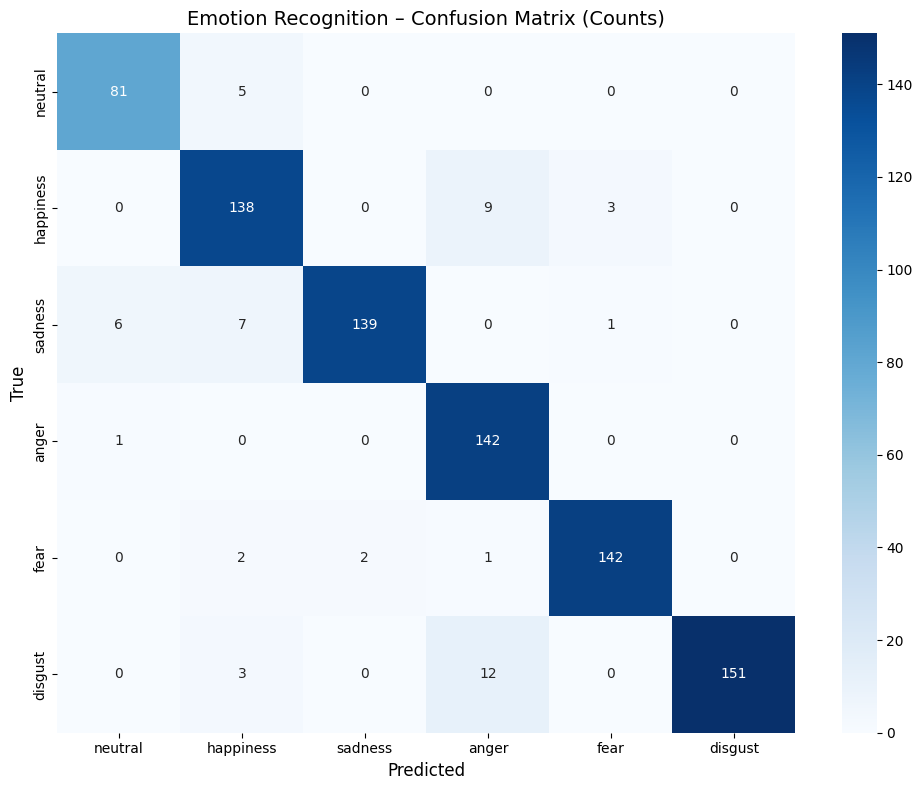

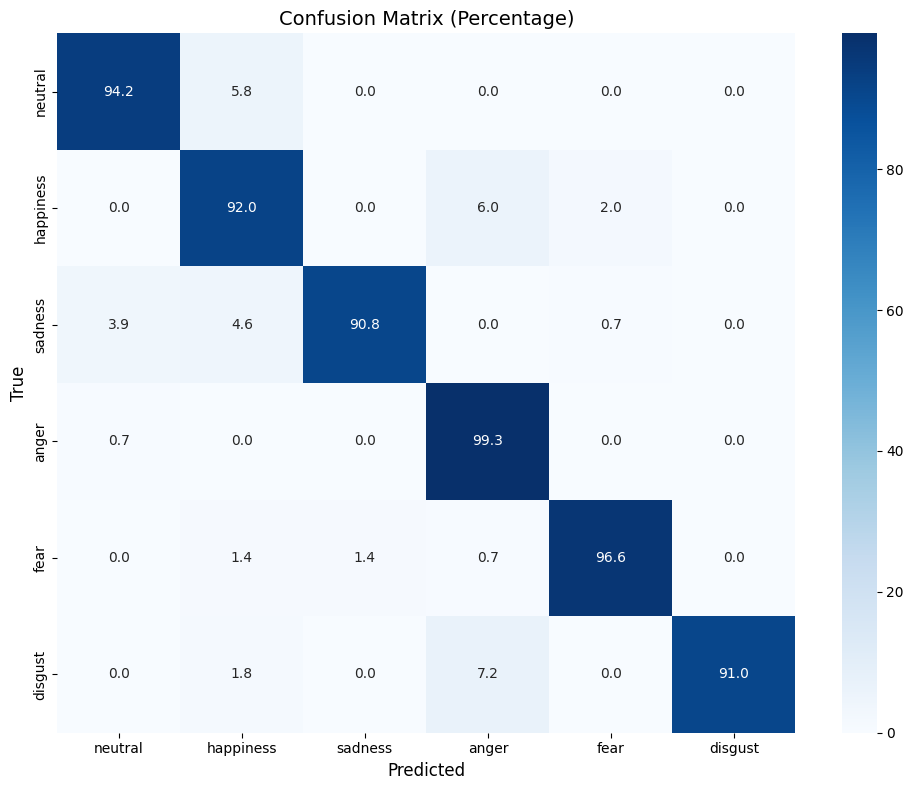

<Figure size 1200x600 with 0 Axes>

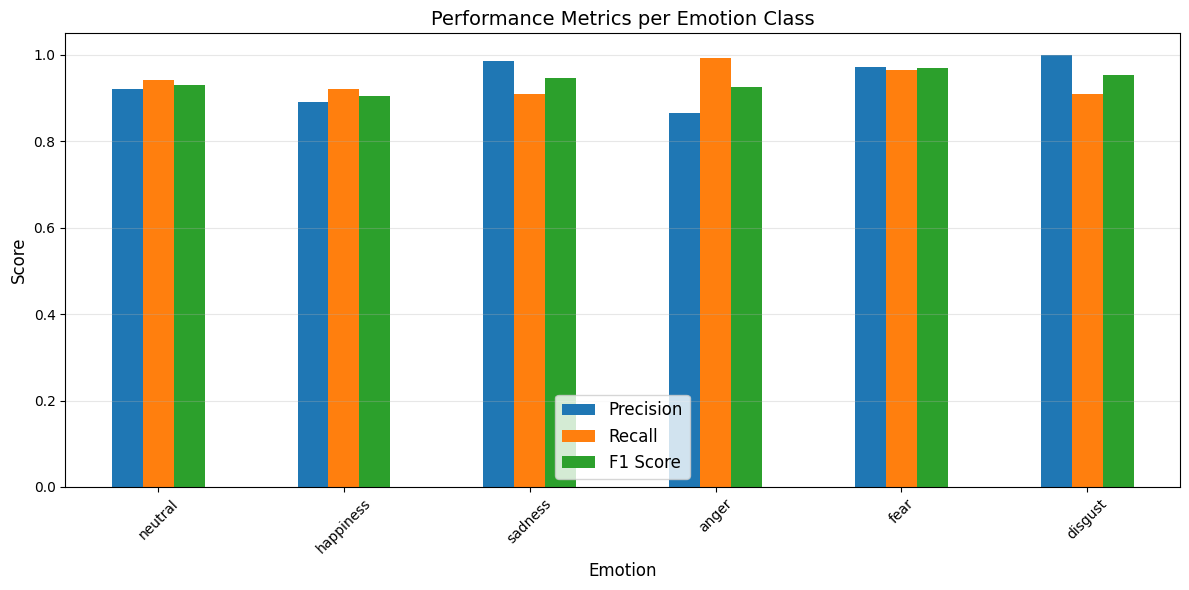

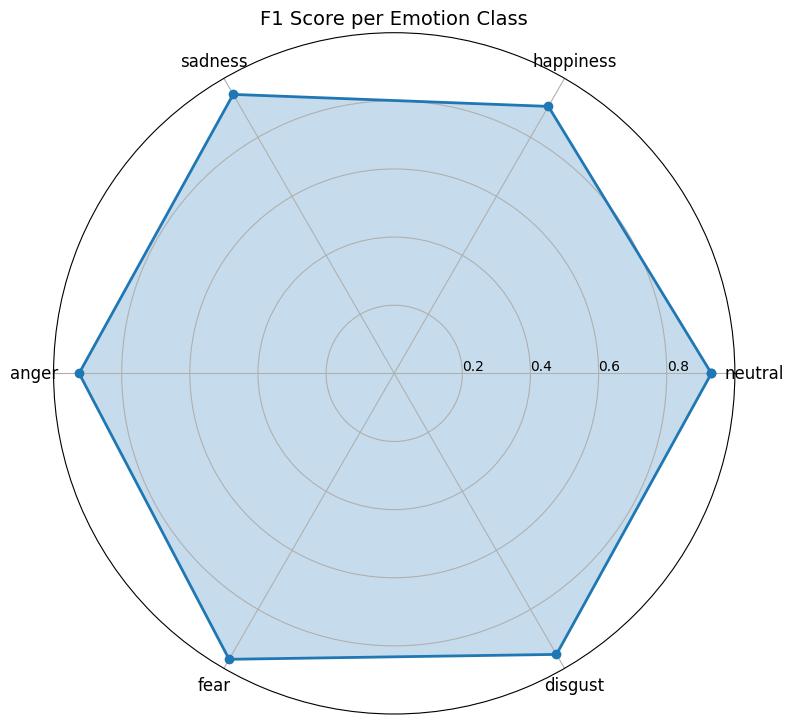

📊 Calculating prediction probabilities...


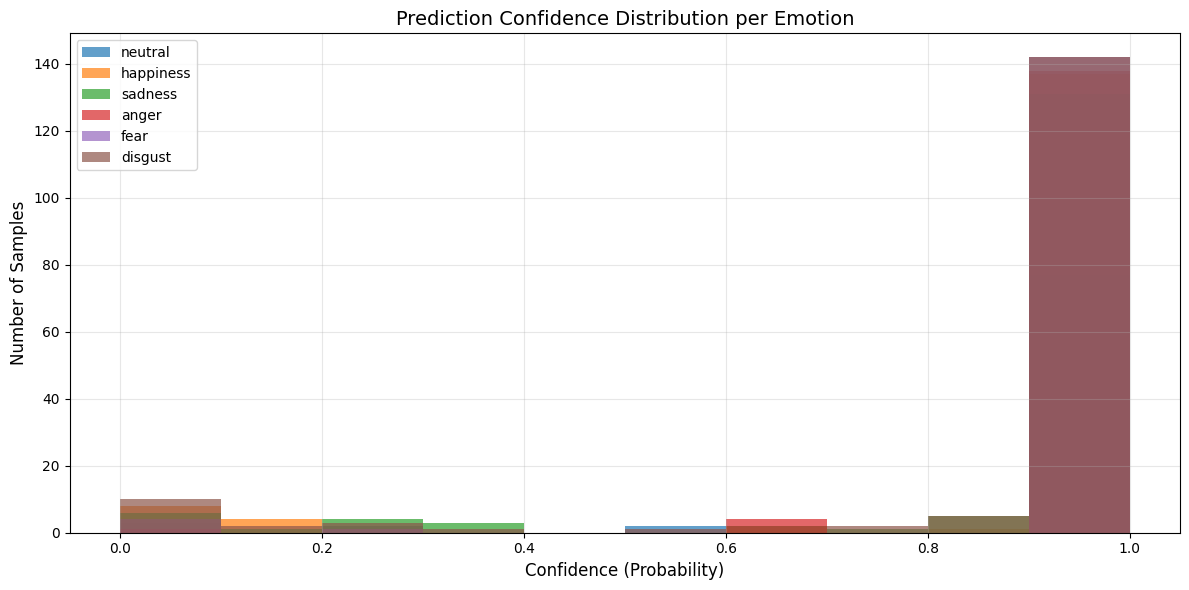

In [ ]:
# . DEVICE SETUP (fixing your error)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("🧪 Evaluating emotion recognition model...")
emotion_eval = evaluate_emotion_recognition(
    model=ser,
    dataloader=test_loader,
    device=device,
)

print(f"Accuracy : {emotion_eval['accuracy']:.4f}")
print(f"Precision: {emotion_eval['precision']:.4f}")
print(f"Recall   : {emotion_eval['recall']:.4f}")
print(f"F1‑score : {emotion_eval['f1']:.4f}")

# . ENHANCED CONFUSION MATRIX
# Set up a larger figure for better visibility
plt.figure(figsize=(10, 8))

# Create a confusion matrix as a percentage of true labels
cm = emotion_eval['confusion_matrix']
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Generate the heatmap with both counts and percentages
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=emotions, yticklabels=emotions
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Emotion Recognition – Confusion Matrix (Counts)', fontsize=14)
plt.tight_layout()
plt.show()

# Percentage version
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_percentage, annot=True, fmt='.1f', cmap='Blues',
    xticklabels=emotions, yticklabels=emotions
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix (Percentage)', fontsize=14)
plt.tight_layout()
plt.show()

# . PER-CLASS METRICS VISUALIZATION
# Calculate per-class precision, recall, and F1
from sklearn.metrics import precision_recall_fscore_support

# Extract the true labels and predictions
y_true = emotion_eval['labels']
y_pred = emotion_eval['predictions']

# Calculate metrics per class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=range(len(emotions))
)

# Create a DataFrame for easier visualization
import pandas as pd
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
}, index=emotions)

# Plot the per-class metrics
plt.figure(figsize=(12, 6))
metrics_df[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(12, 6))
plt.title('Performance Metrics per Emotion Class', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Emotion', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#  RADAR CHART FOR EMOTION RECOGNITION PERFORMANCE
# Prepare the radar chart
def radar_chart(categories, values, title):
    # Number of variables
    N = len(categories)

    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Values to complete the loop
    values = np.concatenate((values, [values[0]]))

    # Initialize the figure
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories, fontsize=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], fontsize=10)
    plt.ylim(0, 1)

    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2)

    # Fill area
    ax.fill(angles, values, alpha=0.25)

    # Add title
    plt.title(title, size=14)

    # Show the graph
    plt.tight_layout()
    plt.show()

# Create radar chart for F1 scores
radar_chart(
    categories=emotions,
    values=f1,
    title='F1 Score per Emotion Class'
)

# 4. PREDICTION CONFIDENCE VISUALIZATION
# This would require the softmax outputs from the model, which we don't have directly
# Let's add a function to get prediction probabilities for the test set

def get_prediction_probabilities(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['mel_spectrogram'].to(device)
            labels = batch['emotion']

            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_probs), np.array(all_labels)

# Get prediction probabilities
print("📊 Calculating prediction probabilities...")
probs, labels = get_prediction_probabilities(ser, test_loader, device)

# Visualize prediction confidence distribution
plt.figure(figsize=(12, 6))
for i, emotion in enumerate(emotions):
    # Get samples of this class
    indices = np.where(labels == i)[0]
    if len(indices) > 0:
        # Get the predicted probability for the correct class
        confidence = probs[indices, i]
        plt.hist(confidence, alpha=0.7, label=emotion, bins=10, range=(0, 1))

plt.title('Prediction Confidence Distribution per Emotion', fontsize=14)
plt.xlabel('Confidence (Probability)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

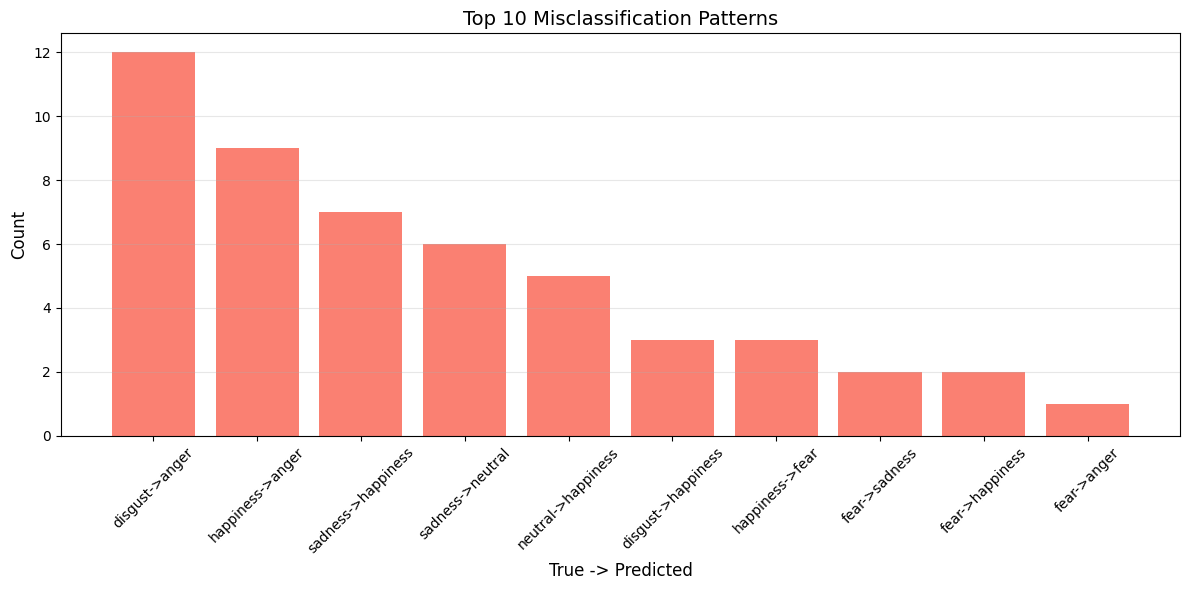

✅ Evaluation complete with enhanced visualizations!


In [ ]:
#  MISCLASSIFICATION ANALYSIS
# Find the top misclassified samples
misclassified = np.where(np.array(y_pred) != np.array(y_true))[0]
misclassification_count = {}

for i in misclassified:
    true_label = emotions[y_true[i]]
    pred_label = emotions[y_pred[i]]
    pair = (true_label, pred_label)
    misclassification_count[pair] = misclassification_count.get(pair, 0) + 1

# Sort by count
sorted_misclassifications = sorted(
    misclassification_count.items(),
    key=lambda x: x[1],
    reverse=True
)

# Visualize the top misclassifications
plt.figure(figsize=(12, 6))
pairs = [f"{true}->{pred}" for (true, pred), _ in sorted_misclassifications[:10]]
counts = [count for _, count in sorted_misclassifications[:10]]

plt.bar(pairs, counts, color='salmon')
plt.title('Top 10 Misclassification Patterns', fontsize=14)
plt.xlabel('True -> Predicted', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Evaluation complete with enhanced visualizations!")

## Evaluation inspect a single enhanced signal

In [ ]:
def plot_mel(mel, title=None):
    if isinstance(mel, torch.Tensor):
        mel = mel.squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        mel, sr=SR, hop_length=HOP,
        y_axis='mel', x_axis='time'
    )
    plt.colorbar(format='%+2.0f dB')
    if title: plt.title(title)
    plt.tight_layout(); plt.show()

Target emotion: sadness


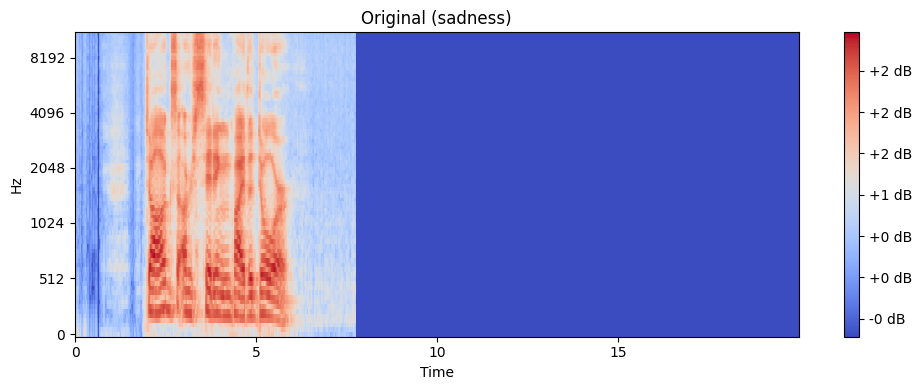

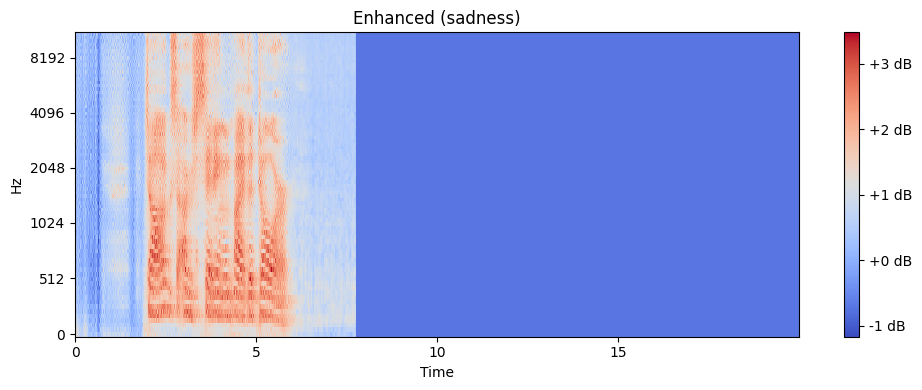

Play audio …


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
SR = 22050
HOP = 512


batch = next(iter(test_loader))
mel   = batch['mel_spectrogram'][0].to(DEVICE)
idx   = batch['emotion'][0].item()
print("Target emotion:", emotions[idx])

# run enhancement
enh   = sampler.enhance_emotion(mel, idx, steps=20)

# plot original vs enhanced
plot_mel(mel.cpu(),  f"Original ({emotions[idx]})")
plot_mel(enh,        f"Enhanced ({emotions[idx]})")

# play audio with explicit rate
print("Play audio …")
orig_audio = librosa.feature.inverse.mel_to_audio(
    mel.squeeze().cpu().numpy(), sr=SR, hop_length=HOP
)
enh_audio  = librosa.feature.inverse.mel_to_audio(
    enh.squeeze().numpy(), sr=SR, hop_length=HOP
)
display(Audio(orig_audio, rate=SR))
display(Audio(enh_audio,  rate=SR))

**Enhance test subset & evaluate performance**

✨ Enhancing subset...


100%|██████████| 10/10 [02:20<00:00, 14.04s/it]



 Original subset evaluation …

 Enhanced subset evaluation …

✅ Accuracy  – original: 1.0000  |  enhanced: 0.2000
✅ F1-score – original: 1.0000  |  enhanced: 0.2083


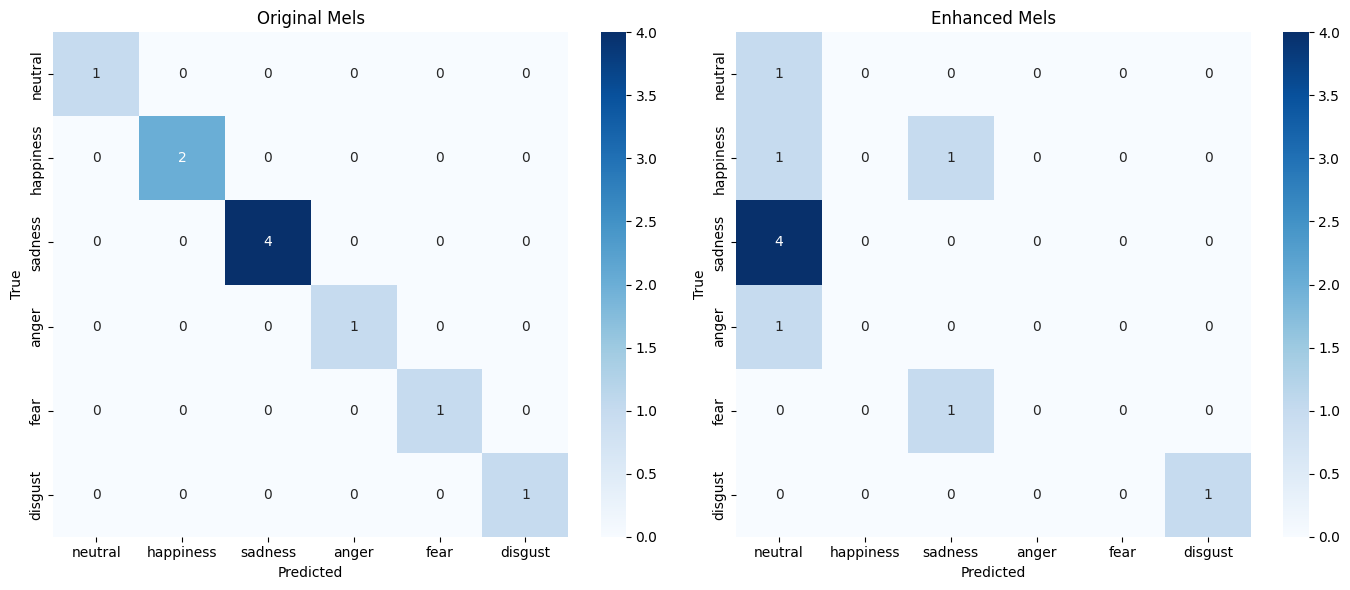

In [ ]:
from torch.utils.data import Dataset, DataLoader

test_dataset = test_ds  # Alias for clarity in later cells

# --- Subset to enhance (e.g., 100 samples to save memory)
subset_size = min(10, len(test_dataset))
subset_idxs = list(range(subset_size))
test_subset = torch.utils.data.Subset(test_dataset, subset_idxs)

# --- Enhance all subset samples with diffusion model
enhanced_mels, enhanced_labels = [], []

print("✨ Enhancing subset...")
for sample in tqdm(test_subset):
    mel   = sample['mel_spectrogram'].to(DEVICE)
    label = sample['emotion']
    with torch.no_grad():
        enhanced = sampler.enhance_emotion(mel, label, steps=50)
    enhanced_mels.append(enhanced.cpu())
    enhanced_labels.append(label)
    torch.cuda.empty_cache()

# --- Wrap into dataset
class EnhancedDataset(Dataset):
    def __init__(self, mels, labels):
        self.mels   = mels
        self.labels = labels
    def __len__(self): return len(self.mels)
    def __getitem__(self, idx):
        return {
            'mel_spectrogram': self.mels[idx].unsqueeze(0),  # add channel dim
            'emotion': self.labels[idx]
        }

enh_dataset     = EnhancedDataset(enhanced_mels, enhanced_labels)
enh_dataloader  = DataLoader(enh_dataset, batch_size=1, shuffle=False, num_workers=0)
subset_loader   = DataLoader(test_subset, batch_size=1, shuffle=False, num_workers=0)

# --- Evaluation function
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def evaluate_emotion_recognition(model, loader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            mel = batch['mel_spectrogram'].to(device)

            # Ensure shape is [batch, channels, height, width]
            if mel.dim() == 3:         # [channels, height, width]
                mel = mel.unsqueeze(0)
            elif mel.dim() == 5:       # [1, 1, 1, 80, 861] → remove extra dim
                mel = mel.squeeze(1)
            elif mel.dim() != 4:
                raise ValueError(f"Unexpected input shape: {mel.shape}")
            lab = batch['emotion'].to(device)
            out = model(mel)
            pred = out.argmax(1)
            preds.extend(pred.cpu().numpy())
            trues.extend(lab.cpu().numpy())
    acc = accuracy_score(trues, preds)
    f1  = f1_score(trues, preds, average='macro')
    cm  = confusion_matrix(trues, preds)
    return {'accuracy': acc, 'f1': f1, 'confusion_matrix': cm}

# --- Compare original vs enhanced
print("\n Original subset evaluation …")
orig_metrics = evaluate_emotion_recognition(ser, subset_loader, device=DEVICE)

print("\n Enhanced subset evaluation …")
enh_metrics = evaluate_emotion_recognition(ser, enh_dataloader, device=DEVICE)

# --- Report results
print(f"\n✅ Accuracy  – original: {orig_metrics['accuracy']:.4f}  |  enhanced: {enh_metrics['accuracy']:.4f}")
print(f"✅ F1-score – original: {orig_metrics['f1']:.4f}  |  enhanced: {enh_metrics['f1']:.4f}")

# --- Visualize confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(14,6))
for a, cm, title in zip(
    ax,
    [orig_metrics['confusion_matrix'], enh_metrics['confusion_matrix']],
    ['Original Mels', 'Enhanced Mels']):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions, yticklabels=emotions, ax=a)
    a.set_xlabel('Predicted'); a.set_ylabel('True'); a.set_title(title)
plt.tight_layout(); plt.show()